In [14]:
import re
import os
import glob
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

import requests
from tqdm import tqdm
import datetime
import pytz
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shapely  # shapely 2.0

import pvlib
from pvlib.bifacial import pvfactors
from pvlib.location import Location
from pvlib import tracking
from pvlib.bifacial.pvfactors import pvfactors_timeseries
from pvlib import temperature
from pvlib import pvsystem

import bifacialvf
from bifacialvf import loadVFresults

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
home = os.getcwd()

Import Geodataframe 

In [3]:
# Import gdf of political borders
gdf = gpd.read_file("data\\political_borders\\Chile_regions_conti.shp").to_crs(epsg=3857)
# Get latitude and longitude in EPSG 4326
gdf["geometry_centroid"] = gdf["geometry"].centroid.to_crs(epsg = 4326)
gdf["lat_4326"] = gdf["geometry_centroid"].y.round(2)
gdf["long_4326"] = gdf["geometry_centroid"].x.round(2)

# Select Santiago for case study
i = 11
lat = gdf.loc[i,"lat_4326"]
lon = gdf.loc[i,"long_4326"]
tz='America/Santiago'

Get TMY and prepare for vf simulation

In [4]:
# get TMY from PVGIS
def get_TMY(lat_4326, long_4326, tz='America/Santiago',directory="data\\PVGIS_TMY\\"):
    os.chdir(home)
    lat_4326 = round(lat_4326,2)
    long_4326 = round(long_4326,2)

    try: 
        # API request            
        data_pvgis  = pvlib.iotools.get_pvgis_tmy(lat_4326, long_4326, outputformat='json', usehorizon=True, userhorizon=None, startyear=None, endyear=None, url='https://re.jrc.ec.europa.eu/api/v5_2/', map_variables=None, timeout=30)
        
        # Get altitude and tmy data
        tmy_pvg_r = data_pvgis[0]
        altitude = data_pvgis[2].get("location").get("elevation")

        # adapt to local timezone
        timezone = pytz.timezone(tz)
        dt = datetime.datetime.utcnow()
        offset_hours = timezone.utcoffset(dt).seconds / 3600.0
        if offset_hours > 12:
            offset_hours = offset_hours - 24
        if offset_hours < 0:
            offset_hours = int(-offset_hours)
            # Extract the first rows according to the time offset
            first_rows = tmy_pvg_r.head(offset_hours)
            tmy_pvg_r  = tmy_pvg_r.drop(tmy_pvg_r.index[:offset_hours])
            # Concatenate the modified DataFrame and the first three rows
            tmy_pvg = pd.concat([tmy_pvg_r, first_rows])   
        else:
            print("TMY download only for South America")
        tmy_pvg["time"] = pd.date_range(start = "2022-01-01 00:00", end="2022-12-31 23:00", freq="h", tz=tz)
        tmy_pvg.index = tmy_pvg["time"]

        # Information on PVGIS Download
        if (tmy_pvg["G(h)"].sum() < 1):
            download_info = "missing solar data"
        elif (tmy_pvg["WS10m"].sum() < 1) | (tmy_pvg["T2m"].sum() < 1):
            download_info = "missing climate data"
        else:
            download_info = "ok"

        # process tmy data: Rename for pvlib
        cols_to_use = ["time", "T2m", "G(h)", "Gb(n)", "Gd(h)", "IR(h)", "WS10m", "RH", "SP"] 
        pvlib_column_names = ["time", "temp_air", "ghi", "dni", "dhi", "lwr_u", "wind_speed", "rh", "sp" ] 
        tmy_pvg = tmy_pvg[cols_to_use]
        tmy_pvg.columns = pvlib_column_names
        

        location = Location(lat_4326, long_4326, tz, altitude)
        # Get solar azimuth and zenith to store in tmy
        solar_position = location.get_solarposition(times=tmy_pvg.index)
        tmy_pvg["azimuth"] = solar_position["azimuth"] 
        tmy_pvg["zenith"] = solar_position["zenith"] 
        tmy_pvg["elevation"] = 90 - tmy_pvg["zenith"]
        tmy_pvg["apparent_zenith"] = solar_position["apparent_zenith"] 
        tmy_pvg = tmy_pvg.reset_index(drop=True)
        
        # Store meta data
        tmy_pvg.loc[0, "info"] = "lat_4326"
        tmy_pvg.loc[1, "info"] = "long_4326"
        tmy_pvg.loc[2, "info"] = "altitude"
        tmy_pvg.loc[3, "info"] = "PVGIS_dl"

        tmy_pvg.loc[0, "info_values"] = lat_4326
        tmy_pvg.loc[1, "info_values"] = long_4326
        tmy_pvg.loc[2, "info_values"] = altitude
        tmy_pvg.loc[3, "info_values"] = download_info

        # Save as csv
        outFileName = "TMY_" + str(lat_4326)+"_"+str(long_4326)
        tmy_pvg.to_csv(directory+outFileName+".csv", sep=',',encoding='latin-1', index=False)


    except requests.HTTPError as err:
        tmy_pvg = None
        altitude = None
        download_info = err

    return tmy_pvg, altitude, download_info
tmy_pvg, altitude, meta = get_TMY(lat,lon)

# prepare for viewfactors shadow simulation function
def prep_TMY_vf(tmy):
    myTMY3 = tmy.copy()
    myTMY3 = myTMY3[myTMY3["elevation"]>0]
    myTMY3["azimuth"] = np.radians(myTMY3["azimuth"]) 
    myTMY3["zenith"] = np.radians(myTMY3["zenith"]) 
    myTMY3["elevation"] = np.radians(myTMY3["elevation"]) 
    myTMY3["GHI"] = myTMY3["ghi"]
    myTMY3["DNI"] = myTMY3["dni"]
    myTMY3["DHI"] = myTMY3["dhi"]
    myTMY3.index = myTMY3["time"]
    return myTMY3
myTMY3 = prep_TMY_vf(tmy_pvg)

C:\Users\0davi\AppData\Local\Temp\ipykernel_6864\3096662975.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ok' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tmy_pvg.loc[3, "info_values"] = download_info


In [5]:
myTMY3

,time,temp_air,ghi,dni,dhi,lwr_u,wind_speed,rh,sp,azimuth,zenith,elevation,apparent_zenith,info,info_values,GHI,DNI,DHI
time,,,,,,,,,,,,,,,,,,
2022-01-01 07:00:00-03:00,2022-01-01 07:00:00-03:00,15.21,364.40,1168.63,56.60,280.40,0.55,81.10,93764.0,2.012759,1.507554,0.063242,86.189876,NaN,NaN,364.40,1168.63,56.60
2022-01-01 08:00:00-03:00,2022-01-01 08:00:00-03:00,18.20,601.45,1183.20,57.40,283.20,0.97,68.70,93819.0,1.880595,1.304908,0.265889,74.710065,NaN,NaN,601.45,1183.20,57.40
2022-01-01 09:00:00-03:00,2022-01-01 09:00:00-03:00,20.49,808.85,1159.86,66.95,290.20,1.31,61.40,93745.0,1.755960,1.093738,0.477059,62.636612,NaN,NaN,808.85,1159.86,66.95
2022-01-01 10:00:00-03:00,2022-01-01 10:00:00-03:00,22.71,967.65,1131.68,72.90,301.60,1.72,54.45,93727.0,1.627960,0.877565,0.693231,50.262077,NaN,NaN,967.65,1131.68,72.90
2022-01-01 11:00:00-03:00,2022-01-01 11:00:00-03:00,24.54,1078.60,1106.33,80.15,309.80,2.07,49.20,93680.0,1.478460,0.659848,0.910948,37.794431,NaN,NaN,1078.60,1106.33,80.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 16:00:00-03:00,2022-12-31 16:00:00-03:00,25.69,647.85,769.82,91.10,325.10,2.39,41.57,93542.0,4.902693,0.545129,1.025668,31.224129,NaN,NaN,647.85,769.82,91.10
2022-12-31 17:00:00-03:00,2022-12-31 17:00:00-03:00,24.86,401.35,492.89,126.75,321.24,2.20,44.55,93532.0,4.727986,0.761810,0.808987,43.633627,NaN,NaN,401.35,492.89,126.75
2022-12-31 18:00:00-03:00,2022-12-31 18:00:00-03:00,24.04,246.05,514.04,56.95,317.38,2.00,47.53,93504.0,4.592237,0.979317,0.591479,56.087629,NaN,NaN,246.05,514.04,56.95


Technical Parameters for APV System

In [6]:
#          This program calculates irradiances on the front and back surfaces of bifacial PV modules.
#          Key dimensions and nomenclature:

tilt = 10               # PV module tilt angle from horizontal, in degrees
sazm = 0                # PV module surface azimuth from north, in degrees
albedo = None           # Calculated in previous section from SRRL data. Value is 0.28 up to 11/18/19o
# 1.0 = normalized PV module/panel slant height other variables are based on that
clearance_height = 2    # normalized by PV panel width
pitch = 3               # pitch = x1 + D, row-to-row distance, from front of module to front of module in next row, in PV module/panel slant heights, with x1 = cos(tilt), horizontal PV module dimension, in PV module/panel slant heights
rowType = "interior"    # RowType(first interior last single)
transFactor = 0         # TransmissionFactor(open area fraction)
sensorsy = 12           # sensorsy = number of horizontal results, usually corresponding to the rows of cells in a PV module/panel along the slope of the sampled axis. (# hor rows in panel)   <--> THIS ASSUMES LANDSCAPE ORIENTATION 
PVfrontSurface = "glass"    # PVfrontSurface(glass or ARglass)
PVbackSurface = "glass"     # PVbackSurface(glass or ARglass)
agriPV = True

# Tracking instructions
tracking=False
backtrack=False
limit_angle = 65

In [7]:
# Requirements Viewfactors Simulation
testfolder = home + "\\bifacialvf\\"
if not os.path.exists(testfolder):
    os.makedirs(testfolder)
writefiletitle = os.path.join(testfolder, str(lat)+"_"+str(lon)+'_PVGIS.csv')
meta = {'loc': 'LOCATION',
 'city': 'SANTIAGO',
 'state-prov': '-',
 'country': 'CHL',
 'data_type': 'IWEC Data',
 'WMO_code': '855740',
 'latitude': -33.38,
 'longitude': -70.78,
 'TZ': -4.0,
 'altitude': 476.0}
deltastyle = 'TMY3'

# Simulation with NREL viewfactors
bifacialvf.simulate(myTMY3, meta, writefiletitle=writefiletitle, 
            tilt=tilt, sazm=sazm, pitch=pitch, clearance_height=clearance_height, 
            rowType=rowType, transFactor=transFactor, sensorsy=sensorsy, 
            PVfrontSurface=PVfrontSurface, PVbackSurface=PVbackSurface, 
            albedo=albedo, tracking=tracking, backtrack=backtrack, 
            limit_angle=limit_angle, deltastyle=deltastyle, agriPV=agriPV)

No albedo value set or included in TMY3 file (TMY Column name 'Alb (unitless)' expected) Setting albedo default to 0.2
 
 
********* 
Running Simulation for TMY3: 
Location:   SANTIAGO
Lat:  -33.38  Long:  -70.78  Tz  -4.0
Parameters: tilt:  10   Sazm:  0     Clearance_Height :  2   Pitch:  3   Row type:  interior   Albedo:  0.2
Saving into c:\Users\0davi\github\CSET_AV_Chile\bifacialvf\-33.61_-70.63_PVGIS.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.4757041566663107
Actual distance between rows =  2.015192246987792
 
Saving Ground Irradiance Values for AgriPV Analysis. 


  0%|          | 0/4363 [00:00<?, ?it/s]c:\Users\0davi\AppData\Local\Programs\Python\Python39\lib\site-packages\bifacialvf\bifacialvf.py:443: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dni = myTMY3.DNI[rl]#get_value(rl,5,"False")
c:\Users\0davi\AppData\Local\Programs\Python\Python39\lib\site-packages\bifacialvf\bifacialvf.py:444: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dhi = myTMY3.DHI[rl]#get_value(rl,8,"False")
c:\Users\0davi\AppData\Local\Programs\Python\Python39\lib\site-packages\bifacialvf\bifacialvf.py:455: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version,

Finished


Raw Results Analisis

C:\Users\0davi\AppData\Local\Temp\ipykernel_6864\2583016588.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T


Average daily Reference GHI: 5201.83 Wh/m2
Average daily APV GHI: 3317.17 Wh/m2
Shadow under APV System: 36.230718405526055 %


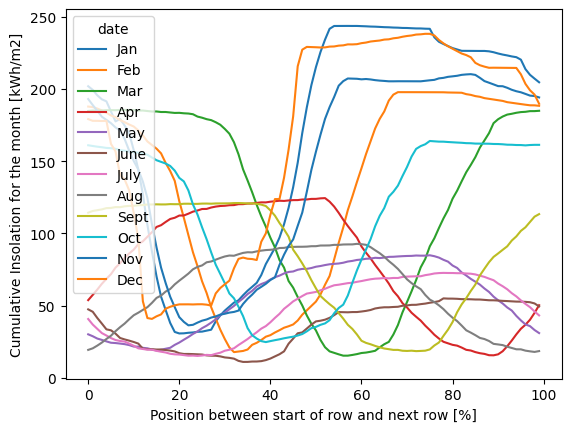

In [8]:
(data, metadata) = loadVFresults(writefiletitle)
data.index = pd.to_datetime(data['date'], utc = True)
data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)

df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
# I'm sure there's a fancier way to do this but hey, this works.
df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",
                   df.columns[4]: "May",df.columns[5]: "June",df.columns[6]: "July",df.columns[7]: "Aug",
                   df.columns[8]: "Sept",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)

fig = (df/1000).plot()
fig.set_xlabel('Position between start of row and next row [%]')
fig.set_ylabel('Cumulative Insolation for the month [kWh/m2]')
print("Average daily Reference GHI: "+str(data["ghi"].groupby([pd.Grouper(freq='D')]).sum().mean().round(2))+" Wh/m2")
print("Average daily APV GHI: "+str(groundIrrads.mean(axis=1).groupby([pd.Grouper(freq='D')]).sum().mean().round(2))+" Wh/m2")
print("Shadow under APV System: "+str(100-(100/data["ghi"].groupby([pd.Grouper(freq='D')]).sum().mean() * groundIrrads.mean(axis=1).groupby([pd.Grouper(freq='D')]).sum().mean()))+" %")

PAR Analisis

In [9]:
# Input Variabels for PAR calculation
PAR_ratio = 0.48                
W_PAR_conversion_factor = 4.57  # Conversion factor from W/m² to µmol photons/m²/s

LSP = 600                       # Light Saturation Point in µmol photons/m²/s
DLI = 16                        # Daily Light Integral in mol photons/m²/s

# Functions for PAR calculation
def read_result_file(resultfilepath):
    # Read and process result file from shadow simulation
    (data, metadata) = loadVFresults(resultfilepath)
    data.index = pd.to_datetime(data['date'], utc = True)
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = pd.DataFrame()
    df["ghi"] = data["ghi"]
    # Get average irradiation under APV
    df["ghi_apv"] = groundIrrads.mean(axis=1)
    return df

def ghi_to_PAR(df, ratio, conversion_factor):
    df_ghi = df.filter(like='ghi')
    df_ghi.columns = df_ghi.columns.str.replace('ghi', 'PAR')
    df_PAR = df_ghi * ratio * conversion_factor
    return df_PAR

def apply_LSP(df, LSP):
    for col in df.filter(like='PAR').columns:
        df[col + '_LSP'] = np.where(df[col] > LSP, LSP, df[col])
    return df

def PAR_integral(df):
    df_PAR = df.filter(like='PAR')
    df_PAR = df_PAR / 1e6 * 3600                                # convert to mol/m2/hour
    df_PAR_d = df_PAR.groupby([pd.Grouper(freq='D')]).sum()
    return df_PAR_d

def apply_DLI(df, DLI):
    for col in df.filter(like='LSP').columns:
        df[col + '_DLI'] = np.where(df[col] > DLI, DLI, df[col])
    return df

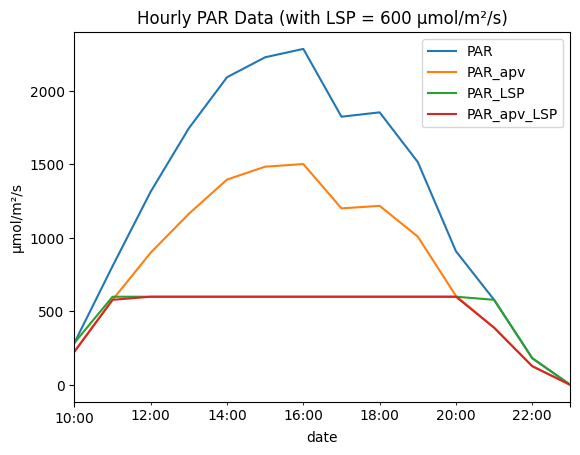

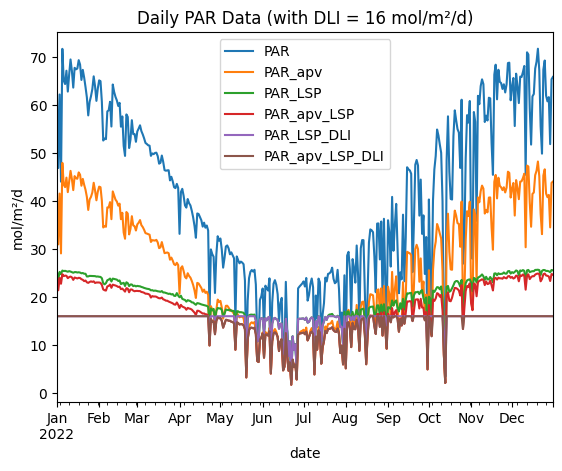

In [10]:
#  Read results and calculate hourly PAR values considering LSP
df = read_result_file(resultfilepath=writefiletitle)
df = pd.concat([df, ghi_to_PAR(df, ratio = PAR_ratio, conversion_factor=W_PAR_conversion_factor)], axis=1) 
df = apply_LSP(df, LSP)

# Plotting hourly PAR data
day = 1
month = 1
ax = df[(df.index.day == day) & (df.index.month == month)][["PAR", "PAR_apv", "PAR_LSP", "PAR_apv_LSP"]].plot()
ax.set_title('Hourly PAR Data (with LSP = '+str(LSP)+' µmol/m²/s)')
ax.set_ylabel('µmol/m²/s')
plt.show()

# Integrate to daily PAR values considering DLI
df_d = PAR_integral(df)
df_d = apply_DLI(df_d, DLI)

ax = df_d[["PAR","PAR_apv","PAR_LSP","PAR_apv_LSP", "PAR_LSP_DLI","PAR_apv_LSP_DLI"]].plot()
ax.set_title('Daily PAR Data (with DLI = '+str(DLI)+' mol/m²/d)')
ax.set_ylabel('mol/m²/d')
plt.show()

C:\Users\0davi\AppData\Local\Temp\ipykernel_6864\3000815301.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_m = df_d.groupby([pd.Grouper(freq='M')]).mean()


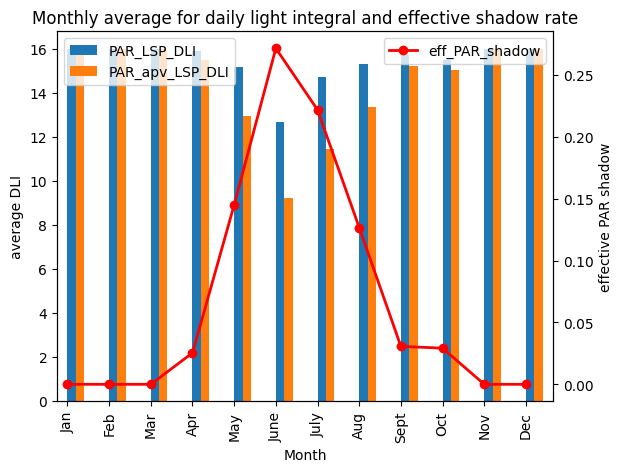

Average daily Reference effective PAR: 15.42 mol/m2/d
Average daily APV effective PAR: 14.41 mol/m2/d
effective PAR Shadow under APV System: 6.590000000000003 %


In [11]:
# Monthly Analisis and effective PAR Shadow Rate
df_m = df_d.groupby([pd.Grouper(freq='M')]).mean()
df_m["eff_PAR_shadow"] = 1- (1 / df_m["PAR_LSP_DLI"] * df_m["PAR_apv_LSP_DLI"])
df_m['Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
df_m.set_index(df_m['Month'], inplace=True)

# Create a figure and an axis object
fig, ax1 = plt.subplots()

# Plot the bar chart for 'PAR_LSP_DLI' and 'PAR_apv_LSP_DLI' on the first y-axis
df_m[['PAR_LSP_DLI', 'PAR_apv_LSP_DLI']].plot(kind='bar', ax=ax1, position=0, width=0.4)
ax1.set_ylabel('average DLI')
ax1.set_title('Monthly average for daily light integral and effective shadow rate')

# Create a second y-axis for the line plot
ax2 = ax1.twinx()
df_m['eff_PAR_shadow'].plot(ax=ax2, color='r', marker='o', linestyle='-', linewidth=2, label='eff_PAR_shadow')
ax2.set_ylabel('effective PAR shadow')

# Add legends
ax1.legend(['PAR_LSP_DLI', 'PAR_apv_LSP_DLI'], loc='upper left')
ax2.legend(['eff_PAR_shadow'], loc='upper right')

# Show the plot
plt.show()

print("Average daily Reference effective PAR: "+str(df_m['PAR_LSP_DLI'].mean().round(2))+" mol/m2/d")
print("Average daily APV effective PAR: "+str(df_m['PAR_apv_LSP_DLI'].mean().round(2))+" mol/m2/d")
print("effective PAR Shadow under APV System: "+str(100-(100/df_m['PAR_LSP_DLI'].mean() * df_m['PAR_apv_LSP_DLI'].mean()).round(2))+" %")

BACKUP

In [15]:
def get_TMY_NREL(lat,lon,deltastyle = 'TMY3', testfolder="\\bifacialvf"):
    # Download and Read input
    os.chdir("C:\\Users\\0davi\\github\\CSET_AV_Chile\\")
    testfolder = os.getcwd() + testfolder
    if not os.path.exists(testfolder):
        os.makedirs(testfolder)
    TMYtoread=bifacialvf.getEPW(lat=lat,lon=lon, path = testfolder)
    myTMY3, meta = bifacialvf.readInputTMY(TMYtoread)
    from bifacialvf.sun import  perezComp,  sunIncident, sunrisecorrectedsunposition #, hrSolarPos, solarPos,
    if not (('azimuth' in myTMY3) and ('zenith' in myTMY3) and ('elevation' in myTMY3)):
        solpos, sunup = sunrisecorrectedsunposition(myTMY3, meta, deltastyle = deltastyle)
        myTMY3['zenith'] = np.radians(solpos['zenith'])
        myTMY3['azimuth'] = np.radians(solpos['azimuth'])
        myTMY3['elevation']=np.radians(solpos['elevation'])
    return myTMY3, meta    

myTMY3, meta = get_TMY_NREL(lat,lon)

path = C:\Users\0davi\github\CSET_AV_Chile\bifacialvf
Getting weather file: CHL_Santiago.855740_IWEC.epw
 ... OK!
Calculating Sun position with a delta of -30 mins. i.e. 12 is 11:30 sunpos


In [16]:
def processing(resultsfile):
    (data, metadata) = loadVFresults(resultsfile)
    data.index = pd.to_datetime(data['date'], utc = True)
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",
                    df.columns[4]: "May",df.columns[5]: "June",df.columns[6]: "July",df.columns[7]: "Aug",
                    df.columns[8]: "Sept",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)

    monthlyGHI = pd.DataFrame(data['ghi'].groupby([pd.Grouper(freq='M')]).sum())
    monthlyGHI['Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    monthlyGHI.set_index(monthlyGHI['Month'], inplace=True)
    monthlyGHI = monthlyGHI.drop(columns='Month')

    df_r = monthlyGHI
    df_r["apv_ghi"] = df.mean()
    return df_r

df_r = processing(writefiletitle)